# <b>시계열 프로젝트4</b>

## <b>비지도학습(2)</b>

### 센서 데이터 이용 및 소개

### 모빌리티 센서 데이터의 활동 분류

In [1]:
import os
import io
import gzip
import pickle
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from scipy import stats
import scipy.cluster.hierarchy as sch

In [2]:
# 미리 구축한 인풋 데이터 다운로드 받기
datapath = 'https://github.com/mchoimis/tsdl/raw/main/motion/'

In [3]:
# 모델 데이터를 업로드할 구글 드라이브와 코랩을 연동하기

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
# Get Present Working Directory
! pwd

/content


In [5]:
# Create new folder
! mkdir motion

In [6]:
cd /content/motion

/content/motion


In [7]:
! ls

In [9]:
# 저장한 데이터와 모델 불러오기

with gzip.open('/content/motion/data.pickle','rb') as f:
    data =  pickle.load(f)
    
with gzip.open('/content/motion/person_id.pickle','rb') as f:
    person_id =  pickle.load(f)

In [10]:
print(np.array(data).shape)
print(np.array(person_id).shape)

(20, 170, 3)
(20,)


In [11]:
list(data)

[array([[12, 42, 35],
        [10, 43, 35],
        [ 7, 42, 34],
        [ 5, 43, 35],
        [ 7, 45, 36],
        [14, 39, 35],
        [11, 38, 37],
        [11, 42, 32],
        [10, 39, 32],
        [10, 41, 31],
        [12, 40, 32],
        [13, 40, 33],
        [14, 42, 32],
        [16, 41, 32],
        [17, 39, 32],
        [18, 40, 32],
        [18, 38, 32],
        [20, 36, 32],
        [19, 39, 33],
        [16, 40, 33],
        [11, 42, 33],
        [ 7, 41, 32],
        [ 4, 43, 33],
        [ 6, 41, 34],
        [12, 40, 35],
        [14, 41, 37],
        [14, 39, 35],
        [11, 40, 33],
        [15, 38, 34],
        [17, 39, 35],
        [19, 39, 34],
        [18, 40, 35],
        [17, 40, 35],
        [17, 41, 34],
        [15, 42, 34],
        [15, 42, 34],
        [14, 39, 34],
        [13, 41, 34],
        [11, 39, 34],
        [ 8, 40, 35],
        [ 5, 43, 33],
        [ 3, 46, 35],
        [ 9, 46, 35],
        [15, 38, 34],
        [13, 36, 32],
        [1

In [12]:
person_id

['f1_1',
 'f1_2',
 'f1_3',
 'f1_4',
 'f1_5',
 'm1_1',
 'm1_2',
 'm2_1',
 'm2_2',
 'f3',
 'f3',
 'f3',
 'f3_1',
 'f3_2',
 'm4',
 'm4',
 'm4',
 'm4',
 'm2',
 'm2']

Text(0.5, 0, 'Time')

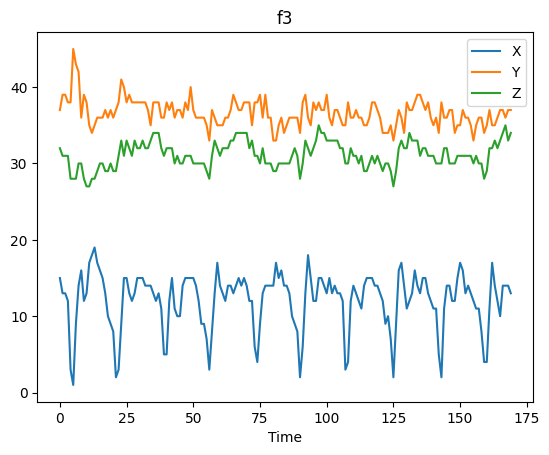

In [13]:
plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [14]:
data = np.asarray(data)

In [15]:
data

array([[[12, 42, 35],
        [10, 43, 35],
        [ 7, 42, 34],
        ...,
        [15, 40, 30],
        [16, 40, 30],
        [17, 39, 31]],

       [[13, 40, 28],
        [14, 39, 29],
        [12, 40, 30],
        ...,
        [16, 38, 28],
        [17, 38, 26],
        [15, 39, 27]],

       [[ 9, 40, 31],
        [ 3, 44, 30],
        [ 5, 43, 34],
        ...,
        [14, 43, 32],
        [14, 42, 31],
        [15, 42, 32]],

       ...,

       [[ 7, 41, 34],
        [ 4, 42, 33],
        [ 6, 40, 32],
        ...,
        [ 7, 40, 36],
        [ 9, 41, 35],
        [12, 40, 35]],

       [[13, 38, 40],
        [ 8, 40, 37],
        [ 5, 38, 36],
        ...,
        [17, 38, 32],
        [17, 37, 33],
        [18, 37, 33]],

       [[13, 38, 42],
        [ 6, 38, 39],
        [ 4, 37, 40],
        ...,
        [10, 41, 32],
        [ 6, 42, 33],
        [ 4, 41, 36]]])

In [16]:
## Standardize 

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

### 심화 Point: 다차원 시계열 클러스터링

In [17]:
# Dimensionality Reduction

In [18]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [19]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170, 3)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 170, 200)         800       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 170, 50)          10050     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 170, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 170, 50)          550       
 tributed)                                                   

In [20]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=200, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

Epoch 1/200
1/1 - 2s - loss: 0.4867 - val_loss: 0.4179 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 0.4179 - val_loss: 0.3534 - 51ms/epoch - 51ms/step
Epoch 3/200
1/1 - 0s - loss: 0.3534 - val_loss: 0.2911 - 51ms/epoch - 51ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2911 - val_loss: 0.2315 - 49ms/epoch - 49ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2315 - val_loss: 0.1762 - 49ms/epoch - 49ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1762 - val_loss: 0.1282 - 48ms/epoch - 48ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1282 - val_loss: 0.0901 - 47ms/epoch - 47ms/step
Epoch 8/200
1/1 - 0s - loss: 0.0901 - val_loss: 0.0636 - 48ms/epoch - 48ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0636 - val_loss: 0.0480 - 59ms/epoch - 59ms/step
Epoch 10/200
1/1 - 0s - loss: 0.0480 - val_loss: 0.0414 - 47ms/epoch - 47ms/step
Epoch 11/200
1/1 - 0s - loss: 0.0414 - val_loss: 0.0412 - 50ms/epoch - 50ms/step
Epoch 12/200
Restoring model weights from the end of the best epoch: 11.
1/1 - 0s - loss: 0.0412 - val_loss: 0.0454 - 68ms

1/1 [==============================] - 0s 160ms/step


Text(0.5, 1.0, 'reconstruction error f3')

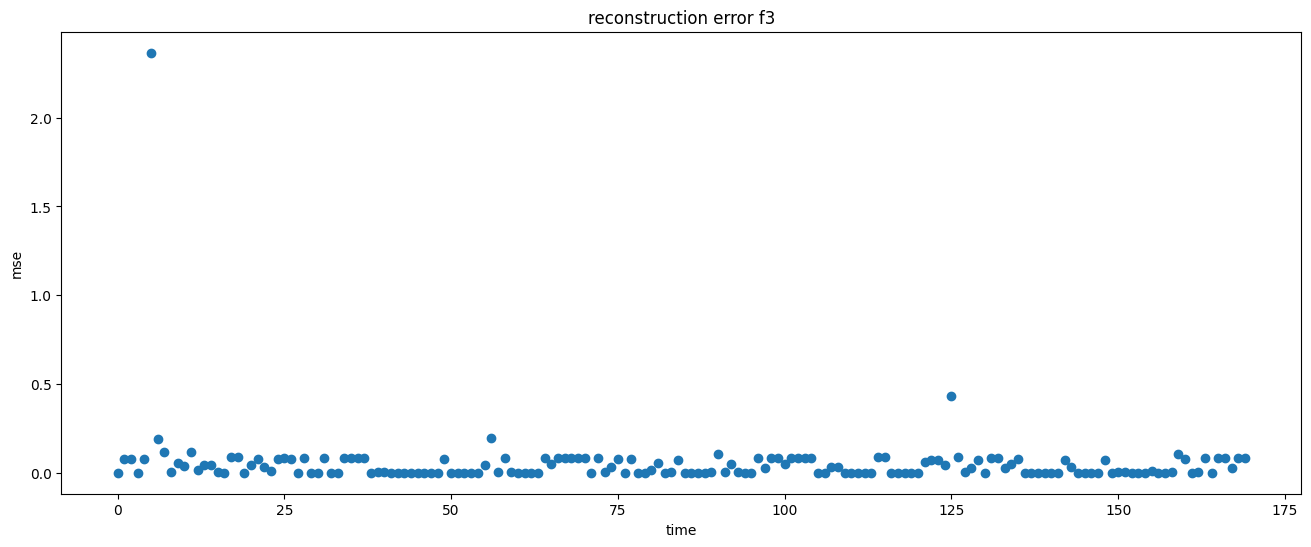

In [21]:
predictions = autoencoder.predict(data[[11]])
mse = np.mean(np.power(data[[11]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.xlabel('time')
plt.ylabel('mse')
plt.title('reconstruction error '+person_id[11])

### 분석결과

In [22]:
# Pearson Correlation CLUSTERING

1/1 [==============================] - 0s 26ms/step


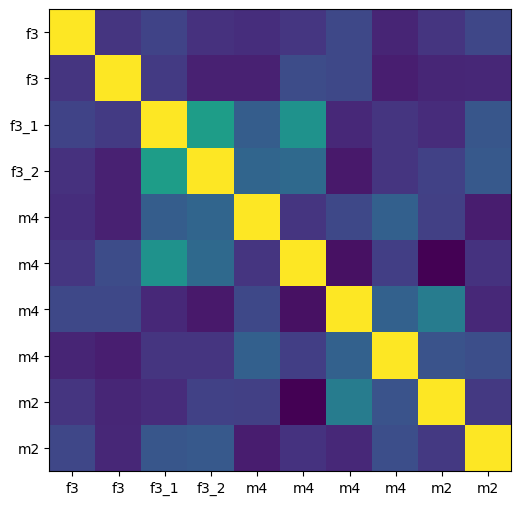

In [23]:
## Cross-correlation matrix 
df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

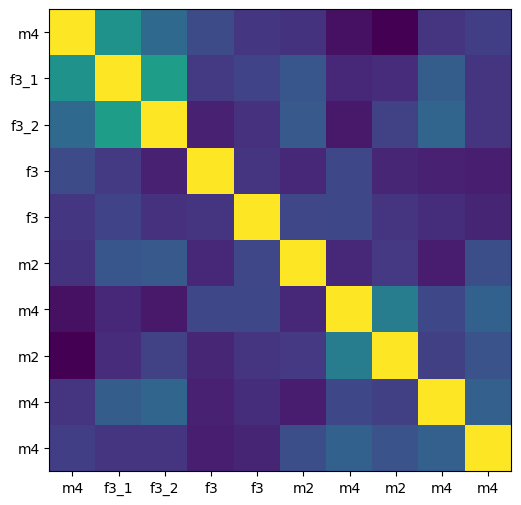

In [25]:
# HIERACHICAL CLUSTERING

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

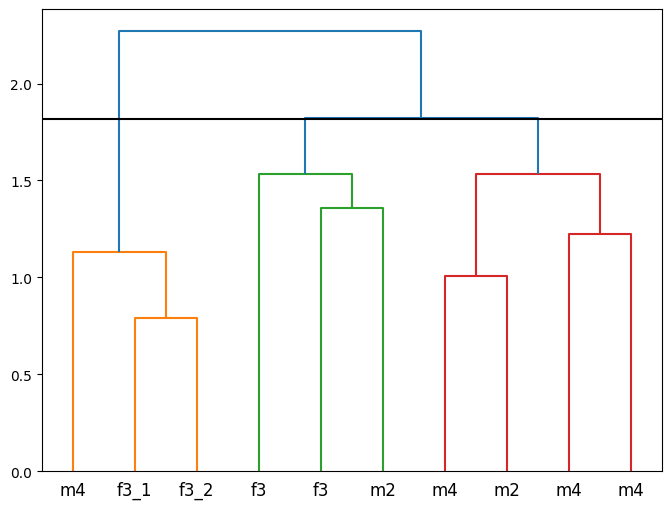

In [26]:
## Dendogram

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

In [27]:
# Kolmogorov-Smirnov CLUSTERING

In [28]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

1/1 [==============================] - 0s 43ms/step


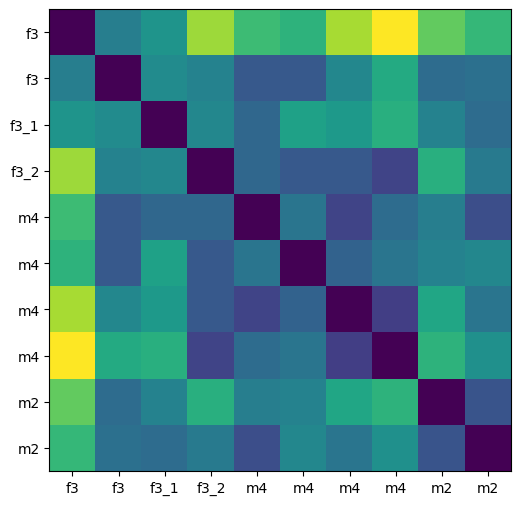

In [29]:
## K-S Matrix ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

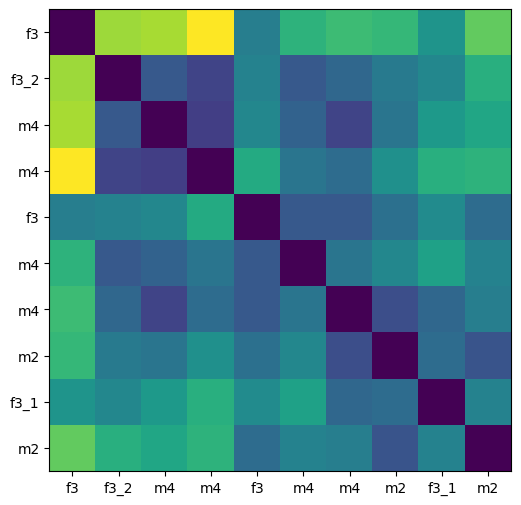

In [30]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

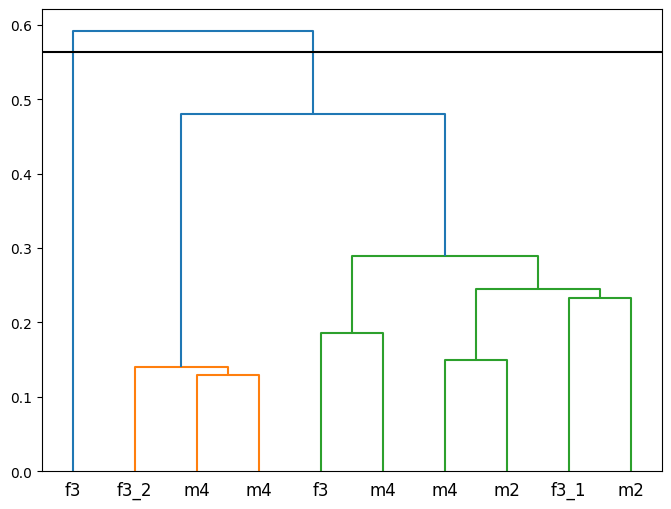

In [31]:
## Dendogram

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')